# 3DeeCellTracker Demo: single mode

This notebook shows how to use 3DeeCellTracker to track cells in single mode.
The demo data can be found in the "single_mode_worm1" folder downloaded from https://osf.io/dt76c/

**The basic procedures:**
- A. Import packages
- B. Initialize the parameters for tracking
- C. Prepare images to be tracked, and the pre-trained U-Net and FFN models.
- D. Optimize segmentation parameters and segment the image at volume 1.
- E. Correct the segmentation at volume 1 (in other image processing software)
- F. Optimize tracking parameters.
- G. Track following volumes.


**Please run following codes according to the instructions**
- Some codes can be skipped if unnecessary.

## A. Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
from matplotlib.animation import FuncAnimation, ArtistAnimation
import CellTracker.tracker as tr
import CellTracker.trackerlite as trl
import CellTracker.stardistwrapper as sdw
import CellTracker.coord_image_transformer as cit
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

## B. Segment cells in all time points by StarDist3D
### Load the trained StarDist3D model

In [2]:
model = sdw.load_stardist_model(model_name="stardist")

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.688901, nms_thresh=0.3.


2023-04-13 15:59:42.089301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 15:59:42.095021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 15:59:42.095471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-13 15:59:42.096116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Segment the volume #1 image and save the results as tiff images

image_shape=(21, 512, 1024)


2023-04-13 15:59:43.229298: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-13 15:59:43.857495: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


Volume 1 has been segmented and saved in ./worm_sd01/auto_vol1/


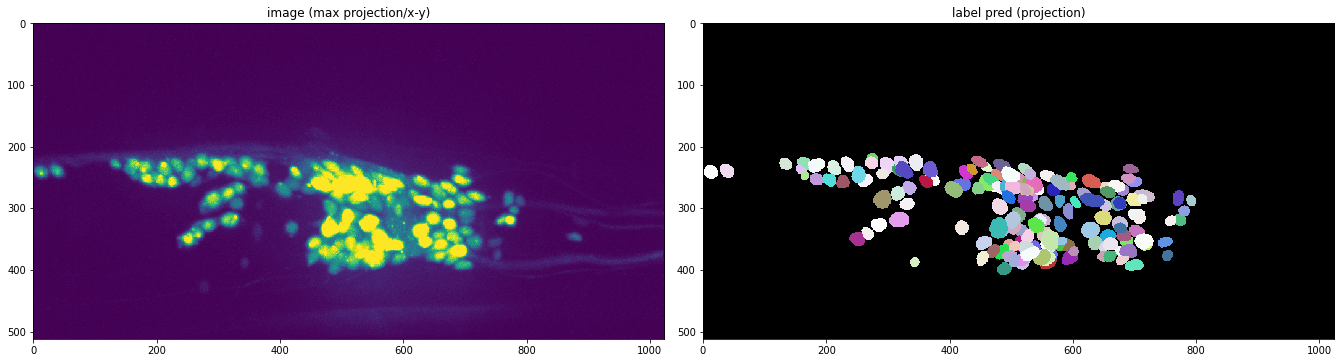

In [3]:
# Set the initial volume number
vol = 1

# Set the file path for the raw images
path_raw_images = "./worm_sd01/data/*t%03d*.tif"

# Set the folder path for the automatic segmentation
auto_segmentation_path = "./worm_sd01/auto_vol1/"

# Load 2D slices of the image stack at the current volume
x = sdw.load_2d_slices_at_time(slice_paths=path_raw_images, t=vol)

# Get the shape of the loaded images
image_shape = x.shape
print(f"{image_shape=}")

# Predict instance labels and details using a trained model
labels, details = model.predict_instances(x)

# Plot the maximum projection of the predicted instance labels
sdw.plot_img_label_max_projection(x, labels, lbl_title="label pred (projection)", fig_width_px=1800)

# If this is the first volume, save the automatic segmentation as tiff files
if vol == 1:
    # Determine whether to use 8-bit or 16-bit image format
    use_8_bit = True if labels.max() <= 255 else False
    # Save the segmented cells of volume #1
    tr.save_automatic_segmentation(labels_xyz=labels.transpose((1,2,0)), folder_path=auto_segmentation_path, use_8_bit=use_8_bit)
    # Print confirmation message
    print(f"Volume 1 has been segmented and saved in {auto_segmentation_path}")

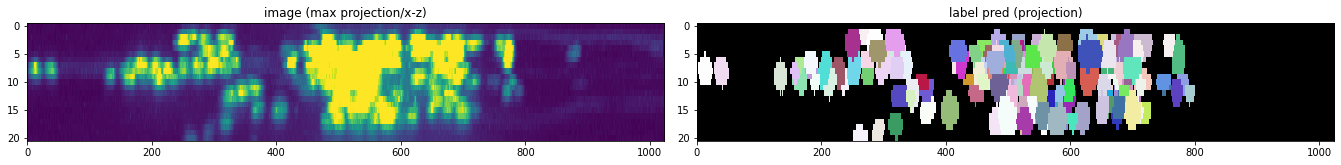

In [4]:
sdw.plot_img_label_max_projection_xz(x, labels, lbl_title="label pred (projection)", fig_width_px=1800, scale_z=9)

### Segment all volumes and save the coordinates of predicted cell centers

In [14]:
#sdw.predict_and_save_coordinates(images_path="./worm_sd01/data/*t%03d*.tif", model=model, coords_path="./worm_sd01/coords/")

Segmenting images:  12%| | 6/50 [00:16<02:00,  2.7
Qhull output at end
qhull precision warning: 
The initial hull is narrow (cosine of min. angle is 0.9999999999999997).
Is the input lower dimensional (e.g., on a plane in 3-d)?  Qhull may
produce a wide facet.  Options 'QbB' (scale to unit box) or 'Qbb' (scale
last coordinate) may remove this warning.  Use 'Pp' to skip this warning.
See 'Limitations' in qh-impre.htm.
Segmenting images: 100%|█| 50/50 [02:25<00:00,  2.

All images from t=1 to t=50 have been Segmented


## C. Manually correct the segmentation at volume 1 and load it.

**C1. Manual correction and move files to the folder**
- Delete non-cell regions;
- Add cells not labeled; 
- correct cell boundaries in other software (such as ITK-SNAP)

- save the corrected segmentation as 2D images (with different z)
- Move the corrected segmentation to the created "/manual_vol1" folder

**C2. Load the manually corrected segmentation**

Loaded the proofed segmentations at vol 1 with 164 cells


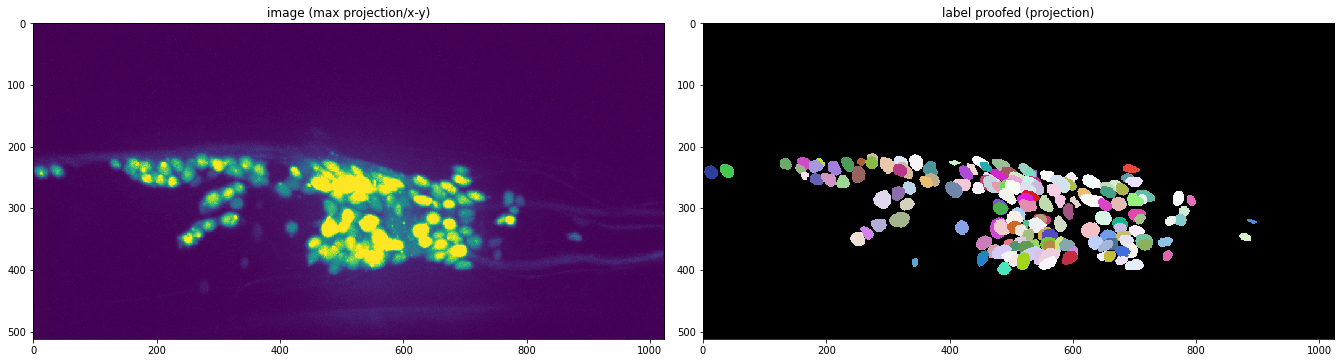

In [36]:
coords2image = cit.CoordsToImageTransformer(track_results_folder="./worm_sd01/track/", voxel_size=(1,1,9.2))
coords2image.load_segmentation(files_path="./worm_sd01/manual_vol1/*.tif")
sdw.plot_img_label_max_projection(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800)

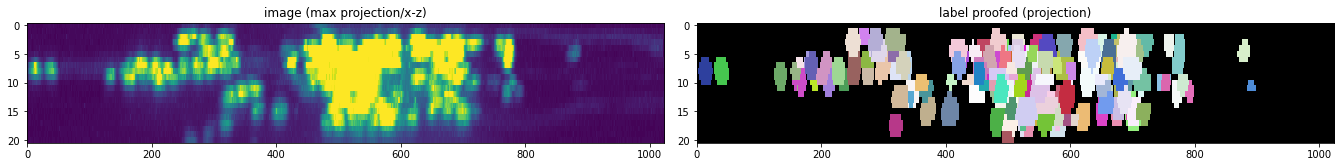

In [24]:
sdw.plot_img_label_max_projection_xz(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800, scale_z=9.2)

**C3. Interpolate cells to make more smooth cell boundary**

In [51]:
coords2image.interpolate(interpolation_factor=10)

Interpolating images along z-axis...
The interpolated segmentations at vol 1 contains 164 cells
Calculating coordinates of cell centers...


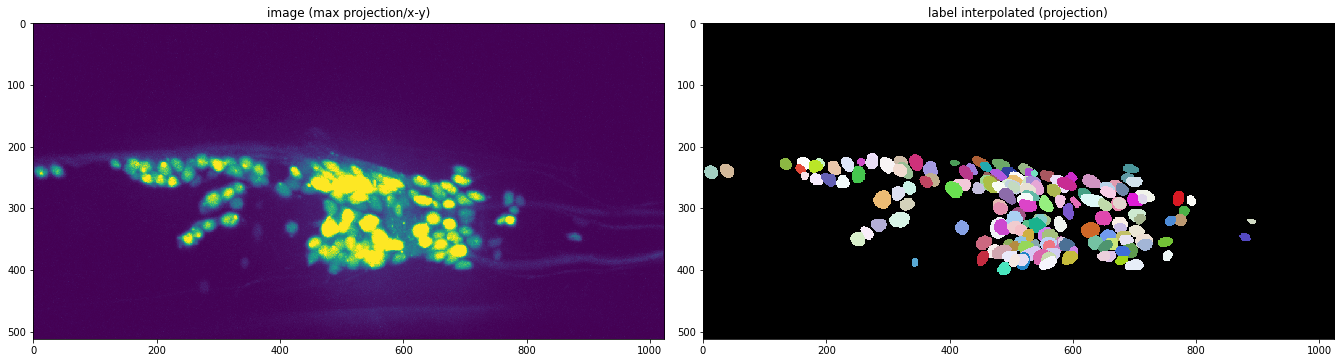

In [7]:
sdw.plot_img_label_max_projection(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800)

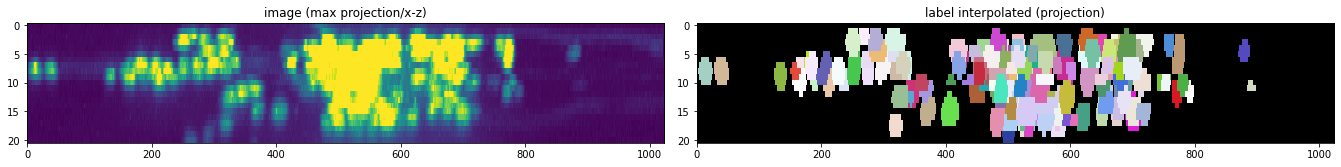

In [8]:
sdw.plot_img_label_max_projection_xz(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800,scale_z=9.2)

**E5. Initiate variables required for tracking**
- cal_subregions(): required by "accurate correction" in following procedures
- check_multicells(): if multiple separated cells were labeled as the same one, generate an error message.

## D. Test tracking. 
**D1. Set paths**

In [14]:
tracker = trl.TrackerLite(coords_dir="./worm_sd01/coords/", ffn_model_path="./ffn_model/ffn_pretrained.h5", track_results_dir="./worm_sd01/track/",
                 proofed_coords_vol1=coords2image.coord_vol1)

 **D2. Test ffn matching**

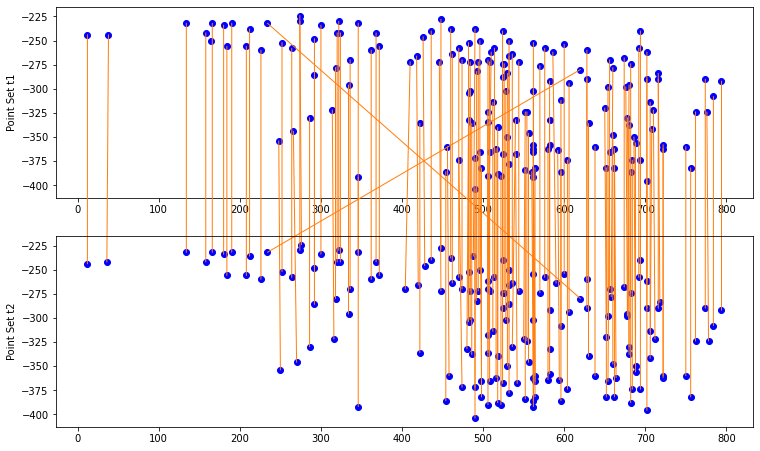

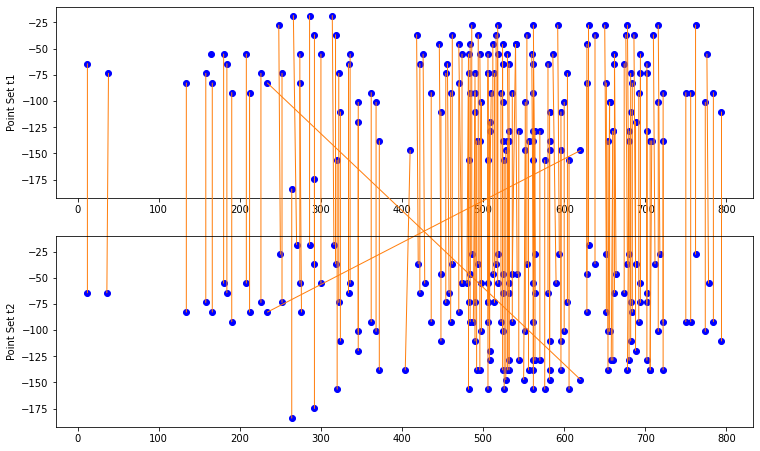

In [83]:
tracker.match_by_ffn(t1=14, t2=15)

**D3. Test FFN + PR-GLS prediction**

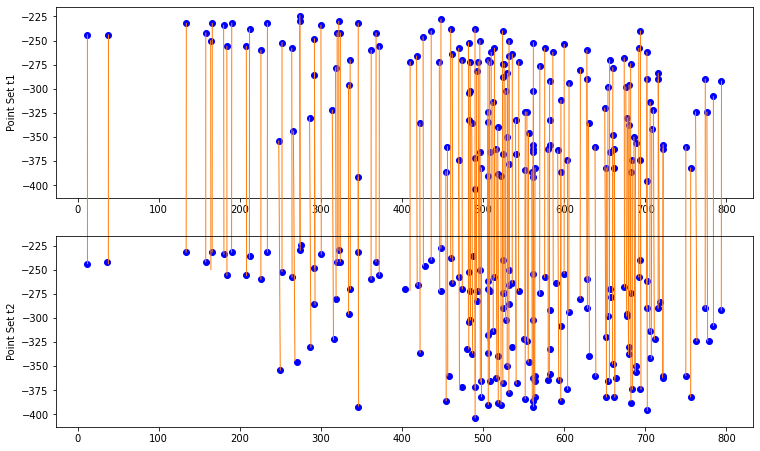

In [99]:
tracked_positions_t2 = tracker.predict_cell_positions(t1=14, t2=15, beta=3, lambda_=3)

**F3. Show the accurate correction after the FFN + PR-GLS transformation**
- Arrows show the correction of the cell positions
- Cells without arrow: no correction.

In [79]:
import numpy as np
t_start, t_end = (1, 50)
confirmed_coord = coords2image.coord_vol1
np.save(tracker.track_results_dir / "coords"/f"confirmed_coords_{str(1).zfill(4)}.npy", confirmed_coord.real)
for t in range(t_start+1, t_end+1):
    print(f"tracking ... t={t}", end="\r")
    confirmed_coord = tracker.predict_cell_positions(t1=t-1, t2=t, confirmed_coord_t1=confirmed_coord, beta=3, lambda_=3, save_fig=True)
    np.save(tracker.track_results_dir / "coords"/f"confirmed_coords_{str(t).zfill(4)}.npy", confirmed_coord.real)

**F4. Show the superimposed cells + labels before/after tracking**

In [ ]:
tracker.draw_overlapping(*results[:3])

## G. Tracking following volumes
**G1. Track and show the processes**

In [ ]:
%matplotlib notebook
fig, ax = tracker.subplots_tracking()
tracker.track(fig, ax, from_volume=2)

**G2. Show the processes as an animation (for diagnosis)**

In [ ]:
%matplotlib inline
track_anim = tracker.replay_track_animation()
HTML(track_anim)